# Part 1: Audio preprocessing (.wav to mfcc)

This notebook discusses the methods for processing **audio files** (speech in our case) to **MFCC** features. 

### Importing necessary variables and libraries along with GSC dataset

In [1]:
%matplotlib inline

In [2]:
## we load some variables from the config file
from config import *

## calculate the window length and hopsize in samples from window length and stride [ms]
lprime = l * int(fs / 1000)
hprime = lprime - s * int(fs / 1000)

In [3]:
## we download the GSC dataset that we will use later
!python3 download_and_prepare_data.py

try loading dataset from  ./data/
there is already a training_list.txt file, in ./data/ abbording!
started processing  testing set
started processing  validation set
started processing  training set
saved metadata as df_all.pkl to  ./data/


In [4]:
## we load some of our own functions and libraries
from utility import load_all_wavs_in_dir

import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import random 
import librosa

In [5]:
## load background noise files to 'noise_data' for later use
noise_data = load_all_wavs_in_dir(direc=brn_directory, sr=16000)

found # of files: 6


### Visualization

We load a recording from the dataset and visualize it as a plot.

In [6]:
y, rate = librosa.load(data_dir + "yes/0132a06d_nohash_0.wav", sr=fs)

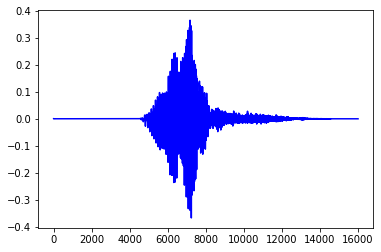

In [7]:
## We can plot it
plt.plot(y, alpha=1., color='blue')

In [8]:
# Listen to it as well
ipd.Audio(y, rate=fs)

We want to build an audio pipeline for the **keyword spotter**. That means we need a function to transform the **.wav** files of our dataset into **spectrograms** or **mfcc** features. To do that, we will use the **librosa** (https://librosa.org/doc/latest/index.html) library.
We use it to calculate the STFT:

its hard to see the interesting, low frequency stuff!


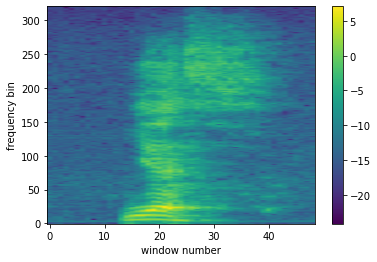

In [9]:
# Calculate the abs value of frequencies at time t
STFT_abs = np.abs(librosa.stft(y, n_fft=lprime, hop_length=hprime, win_length=lprime, center=False))

# Plot. Take the log of the values for better visibility
plt.imshow(np.log(STFT_abs**2), origin='lower', aspect='auto')
# plt.imshow(STFT_abs, origin='lower', aspect='auto')

plt.ylabel('frequency bin')
plt.xlabel('window number' )
plt.colorbar()
print('its hard to see the interesting, low frequency stuff!')

## Exercise 1


1. First, derive a formula for the dimensions of the expected number of frames for a window length $l = 40 ms$, a stride $s = 20 ms$ and a duration of the audio signal of $T = 1s$. How many feature vectors will we get from our 1 second long audio signal?


2. Use librosa built in functions to:
- Calculate a mel spectrogram from the STFT values above. Take the logarithm of the result for better visability. 
- Plot the resulting spectrogram!
- Calculate mfccs from it. 
- Plot the resulting mfccs. 

3. Compare the results of the Fourier transform and mel spectrogram. What did the mel scaling achieve? Why was this useful?

## Hints:
1. Find a formula for the hopsize H in the slides. Calculate it in [ms] from L and S first. From it calculate the hopsize $h$ in samples. Once you have it find the total number of samples $N_s$ and think about how often you can hop by $h$ samples until you are at the end. 
2. Use `librosa.feature.melspectrogram`, `librosa.feature.mfcc` to calculate the spectrogram and mfcc features. You can use the same plotting routines as above. The x-axis is equal in all the plots, but the y-axis is different. 

## Solution

### E1


The function augments the input signal and maybe adds background noise, shifts audio etc.
The audio features are mfccs and are calculated with `librosa.feature.mfcc`, hopsize $h$ is passed as **parameter**. 

The hopsize $H$ in $ms$ is given by:
\begin{equation}
H  = L-S = 20\ ms
\end{equation}

The hopsize $h$ in samples, is:
\begin{equation}
h = H  \ f_s = 320
\end{equation}

The number of frames $N_f$ is: 
\begin{equation}
N_f = [\frac{N_s - s}{h}]   = 49
\end{equation}
where $N_s$ is the number of samples in the $1$ second long audio signal. 

In [10]:
(16000 - 320)/320 

49.0

### E2

now we see it better!


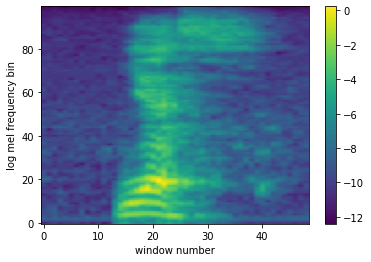

In [11]:
## Rescale this to the mel scale and take log of the values for better visibility
MEL = librosa.feature.melspectrogram(S=STFT_abs, sr=fs, power=1, n_mels=100)

plt.imshow(np.log(MEL), origin='lower', aspect='auto')
plt.ylabel('log mel frequency bin')
plt.xlabel('window number' )
plt.colorbar()
print('now we see it better!')

The mel scaling emphasized the lower frequency parts of the spectrum. In the example we can nicely see the vowel $e$ from the word $yes$ as horizontal bands of fixed frequency. That helps for speech recognition!

finally convert the spectrogram to mfcc features


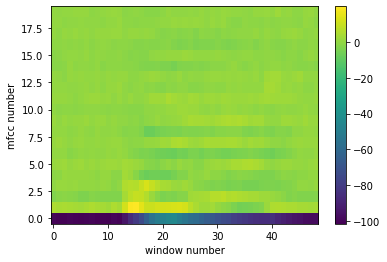

In [12]:
MFCC = librosa.feature.mfcc(S=np.log(MEL))
plt.imshow(MFCC, origin='lower', aspect='auto')
plt.ylabel('mfcc number')
plt.xlabel('window number' )
plt.colorbar()
print('finally convert the spectrogram to mfcc features')

# Part 2: Manipulating audio

Now, we know how to calculate mfcc features and have a feeling for what is going on when looking at spectrograms. In the next part, we will familiarize ourselves a bit more with audio signals by shifting them in time and adding background noise.

### Augmenting audio

In [13]:
from utility import augment_audio

In [14]:
## Load a sample audio file
y, rate = librosa.load(data_dir + "yes/0132a06d_nohash_0.wav", sr=None)

In [15]:
## Function will add background noise to the audio signal:
y_augmented_noise = augment_audio(sig=y, # the signal
                            fs=fs, # sample frequency of the signal
                            padd_audio_to_samples=fs, # audio length is adjusted to this value
                            noise_data = noise_data, # use these noise data
                            background_frequency=1., # 1. means always add background noise
                            Ab=0.3, # with amplitude Ab
                            n_mfccs=0 # 0 --> get the signal directly
                           )

ipd.Audio(y_augmented_noise, rate=16000)

In [16]:
## Also, calculate mfcc features
mfcc_augmented = augment_audio(silence=False, mode='training',
                  sig=y, fs=16000, padd_audio_to_samples=16000,
                  background_frequency=1., noise_data=noise_data, Ab=0.3,
                  l=40, s=20, n_mfccs=16)

mfcc_clean = augment_audio(silence=False, mode='training',
                  sig=y, fs=16000, padd_audio_to_samples=16000,
                  background_frequency=0., noise_data=noise_data, Ab=0.,
                  l=40, s=20, n_mfccs=16)

/Users/paul/Desktop/tutorial_kws/utility.py:124: FutureWarning: Pass y=[ 0.00296477  0.00068805 -0.00128604 ...  0.00505164  0.00293996
  0.00203618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/Users/paul/Desktop/tutorial_kws/utility.py:124: FutureWarning: Pass y=[ 3.0517578e-05 -6.1035156e-05 -1.8310547e-04 ...  9.1552734e-05
 -9.1552734e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,


## Exercise

1. Implement a function called **shift** that shifts the audio signal by $ts$ seconds. You can copy the code below and fill in the blank.

```
def shift(y, ts, fs):
    
    ## shift y
    if ts > 0.:
        
    elif ts < 0.:
    
    else:
        y_shifted = y
    
    return y_shifted
    
```

2. Take the signal $y$ from above and shift it. Compare the original and the shifted signals in a plot and with ipd.Audio. Does the method work?

3. Above we have already created two different mfcc versions of the recording **mfcc_augmented** and **mfcc_clean**. Plot them and compare. What did the addition of background noise do in the result?

## Hints
1. Copy the code below to get a start and fill in the "xxx"s with your own code. 


```
def shift(y, ts, fs):
    ## Randomly time shifts a signal y with sample frequency fs by up to +- ts
    
    ## Copy the signal
    y_shift = np.copy(y)
    
    shift_in_samples = int(np.abs(ts * fs))
    
    ## Perform the shift (different for ts>0, ts<0)
    if ts > 0:
        ## Add 0s to the left and take original signal length starting from sample 0:
        y_shift = np.pad(y_shift, (shift_in_samples, 0), mode='constant')[0:y_shift.shape[0]]
    elif ts < 0:
        ## Add 0s to the right and take original signal length starting from shift in samples:
        "xxx"
    return y_shift
    
```

2. You can start from this code and add the shifted signal that you obtain from using the shift function we just wrote:

```
plt.plot(y, label="original")
plt.legend()
ipd.Audio(y, rate = rate)
```

3. For comparing the mfccs, use fig,axs = plt.subplots(3,) to create three plots. For the first one use axs[0].plot and plot both the original and augmented audio signal in it. For the second and third plot use axs[1].imshow() to display the original mfccs and axs[2].imshow() to display the augmented mfccs, respectively.

### E1

In [17]:
def shift(y, ts, fs):
    '''Randomly time shifts a signal y with sample frequency fs by up to +- ts'''
    
    ## Copy the signal
    y_shift = np.copy(y)
    
    shift_in_samples = int(np.abs(ts * fs))
    
    ## Perform the shift (different for ts>0, ts<0)
    if ts > 0:
        ## Add 0s to the left and take original signal length starting from sample 0:
        y_shift = np.pad(y_shift, (shift_in_samples, 0), mode='constant')[0:y_shift.shape[0]]
    elif ts < 0:
        ## Add 0s to the right and take original signal length starting from shift in samples:
        y_shift = np.pad(y_shift, (0, shift_in_samples), mode='constant')[
                  shift_in_samples:y_shift.shape[0] + shift_in_samples]

    return y_shift

### E2 


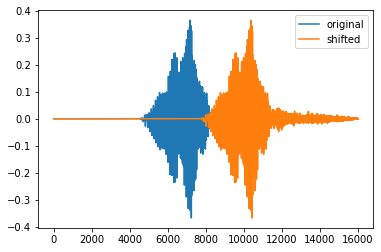

In [18]:
## Plot shifted to see if it works
plt.plot(y, label="original")
y_shifted = shift(y=y, ts=0.2, fs=rate)
plt.plot(y_shifted, label="shifted")
plt.legend()

ipd.Audio(y, rate = rate)

In [19]:
## Listen to shifted audio 
ipd.Audio(y_shifted, rate = rate)

### E3

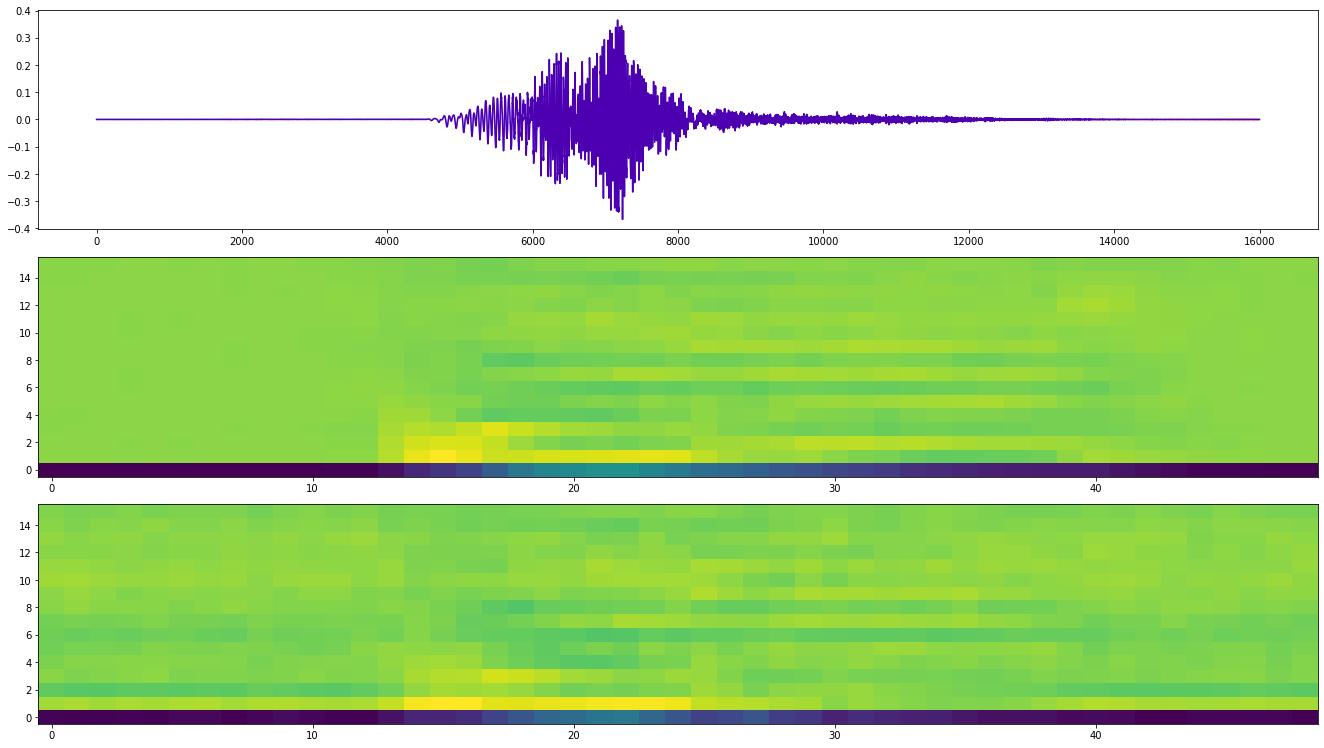

In [20]:
fig,axs = plt.subplots(3,)
fig.set_size_inches(18.5, 10.5)

axs[0].plot(y, color='blue')
axs[0].plot(y_augmented_noise, color='red', alpha=0.3)


i1 = axs[1].imshow(mfcc_clean.T, origin='lower', aspect='auto', label='clean')

i2 = axs[2].imshow(mfcc_augmented.T, origin='lower', aspect='auto', label='augmented')

fig.tight_layout()

### Comparison:
- Additive noise can be seen in the waveform.
- If noise comes from multiple (roughly equally distributed) frequency channels it can be seen in all mfcc coefficients.